In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from prophet import Prophet
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import plotly.express as px
from plotly.subplots import make_subplots

In [2]:
# Step 1: Load and clean the data
df = pd.read_csv('temperatures.csv', parse_dates=['ds'])

# Sort by date
df.sort_values('ds', inplace=True)

#Show missing values
fig = px.line(df,x='ds',y='y')
fig.update_layout(title='Unfilled Dataset')
fig.show()

# Fill missing dates with NaN values
df.set_index('ds', inplace=True)
df = df.asfreq('MS')

# Fill missing temperature values with the previous available value
df['y'].fillna(method='ffill', inplace=True)

# Reset the index
df.reset_index(inplace=True)

# Step 2: Plotting and Analysis
fig = px.line(df,x='ds',y='y')
fig.update_layout(title='Filled Dataset - Monthly Average Land Temperature Over Time', xaxis_title='Date',yaxis_title='Temperature (°C)')
fig.show()


C:\Users\rajamanivinu\AppData\Local\Temp\ipykernel_38248\2633494940.py:17: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



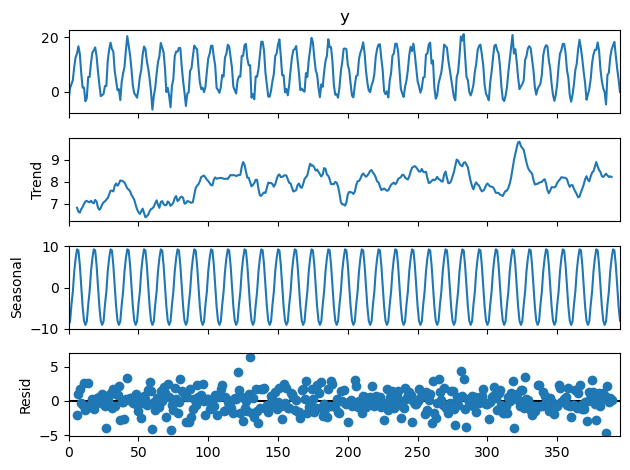

In [3]:

import plotly.graph_objects as go

# Decompose the time series into trend, seasonal, and residual components
decomposition = seasonal_decompose(df['y'], model='additive', period=12)
decomposition.plot()
plt.show()

# Create traces
fig = go.Figure()
fig.add_trace(go.Scatter(y=df.y,
                    mode='lines',
                    name='origina'))
fig.add_trace(go.Scatter(y=decomposition.seasonal,
                    mode='lines',
                    name='seasonal'))
fig.add_trace(go.Scatter(y=decomposition.trend,
                    mode='lines+markers',
                    name='trend'))
fig.add_trace(go.Scatter( y=decomposition.resid,
                    mode='markers', name='resid'))

fig.show()

In [7]:

# Step 3: Split the data into train and test sets
train_size = len(df) - 24
train, test = df.iloc[:train_size], df.iloc[train_size:]

# Step 4: Build three models and compare errors

# Model 1: ARIMA using pmdarima
arima_model = auto_arima(train['y'], seasonal=True, m=12)
arima_predictions = arima_model.predict(n_periods=24)
arima_error = mean_squared_error(test['y'], arima_predictions)

# Model 2: Prophet
prophet_train = train.rename(columns={'ds': 'ds', 'y': 'y'})
prophet_model = Prophet(yearly_seasonality=True)
prophet_model.fit(prophet_train)
future = prophet_model.make_future_dataframe(periods=24, freq='MS')
forecast = prophet_model.predict(future)
prophet_predictions = forecast['yhat'].iloc[-24:].values
prophet_error = mean_squared_error(test['y'], prophet_predictions)

# Model 3: Exponential Smoothing
exp_smoothing_model = ExponentialSmoothing(train['y'], seasonal='add', seasonal_periods=12).fit()
exp_smoothing_predictions = exp_smoothing_model.forecast(24)
exp_smoothing_error = mean_squared_error(test['y'], exp_smoothing_predictions)

# Display the errors
errors_df = pd.DataFrame({
    'Model': ['ARIMA', 'Prophet', 'Exponential Smoothing'],
    'MSE': [arima_error, prophet_error, exp_smoothing_error]
})

print(errors_df)

11:34:40 - cmdstanpy - INFO - Chain [1] start processing
11:34:40 - cmdstanpy - INFO - Chain [1] done processing


                   Model       MSE
0                  ARIMA  2.639313
1                Prophet  2.672321
2  Exponential Smoothing  2.612387
